In [1]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm
from timm import create_model
from IPython.display import display
import gc

from fastai.vision.all import *

(#5) [Path('../input/petfinder-pawpularity-score/sample_submission.csv'),Path('../input/petfinder-pawpularity-score/train.csv'),Path('../input/petfinder-pawpularity-score/test.csv'),Path('../input/petfinder-pawpularity-score/test'),Path('../input/petfinder-pawpularity-score/train')]

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path
0,0,1,1,1,0,0,0,0,0,0,1,0,35,../input/petfinder-pawpularity-score/train/093a98eacf91b2ec104fc1da28c60dc3.jpg
1,0,0,0,1,0,0,0,0,1,0,0,0,31,../input/petfinder-pawpularity-score/train/3502775be0d0935b507ddf7864facd65.jpg
2,0,1,1,1,0,0,0,0,0,0,0,0,40,../input/petfinder-pawpularity-score/train/bf68040faf8f3f0b35755c795ca08fd1.jpg
3,0,1,1,1,0,0,0,0,0,0,0,0,28,../input/petfinder-pawpularity-score/train/a974610d3b42b6b901276210144d834e.jpg
4,0,0,0,1,0,0,0,0,1,1,0,0,30,../input/petfinder-pawpularity-score/train/173218368c3a01062359b4052ba64854.jpg



There are 9912 images

The mean Pawpularity score is 38.03904358353511
The median Pawpularity score is 33.0
The standard deviation of the Pawpularity score is 20.59199010577457

There are 100 unique values of Pawpularity score



0       0.35
1       0.31
2       0.40
3       0.28
4       0.30
        ... 
9907    0.23
9908    0.27
9909    0.67
9910    0.48
9911    0.25
Name: norm_score, Length: 9912, dtype: float64

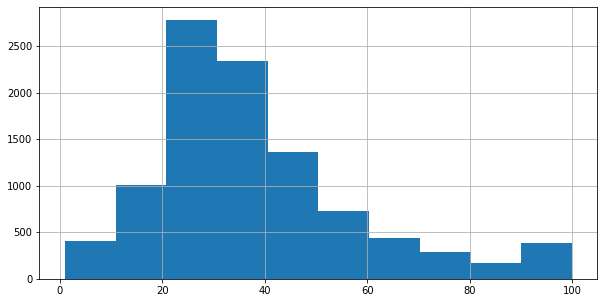

In [2]:
set_seed(365, reproducible=True)
BATCH_SIZE = 32                       # was 32

# def get_train_df():
dataset_path = Path('../input/petfinder-pawpularity-score/')
display(dataset_path.ls())

train_df = pd.read_csv(dataset_path/'train.csv')
print()
display(train_df.head())

train_df['path'] = train_df['Id'].map(lambda x:str(dataset_path/'train'/x)+'.jpg')
train_df = train_df.drop(columns=['Id'])
train_df = train_df.sample(frac=1).reset_index(drop=True) #shuffle dataframe
print()
display(train_df.head())
#     return train_df

# train_df = get_train_df()
len_df = len(train_df)
print()
print(f"There are {len_df} images")

train_df['Pawpularity'].hist(figsize = (10, 5))
print()
print(f"The mean Pawpularity score is {train_df['Pawpularity'].mean()}")
print(f"The median Pawpularity score is {train_df['Pawpularity'].median()}")
print(f"The standard deviation of the Pawpularity score is {train_df['Pawpularity'].std()}")
print()
print(f"There are {len(train_df['Pawpularity'].unique())} unique values of Pawpularity score")

train_df['norm_score'] = train_df['Pawpularity']/100
print()
display(train_df['norm_score'])

1280 848


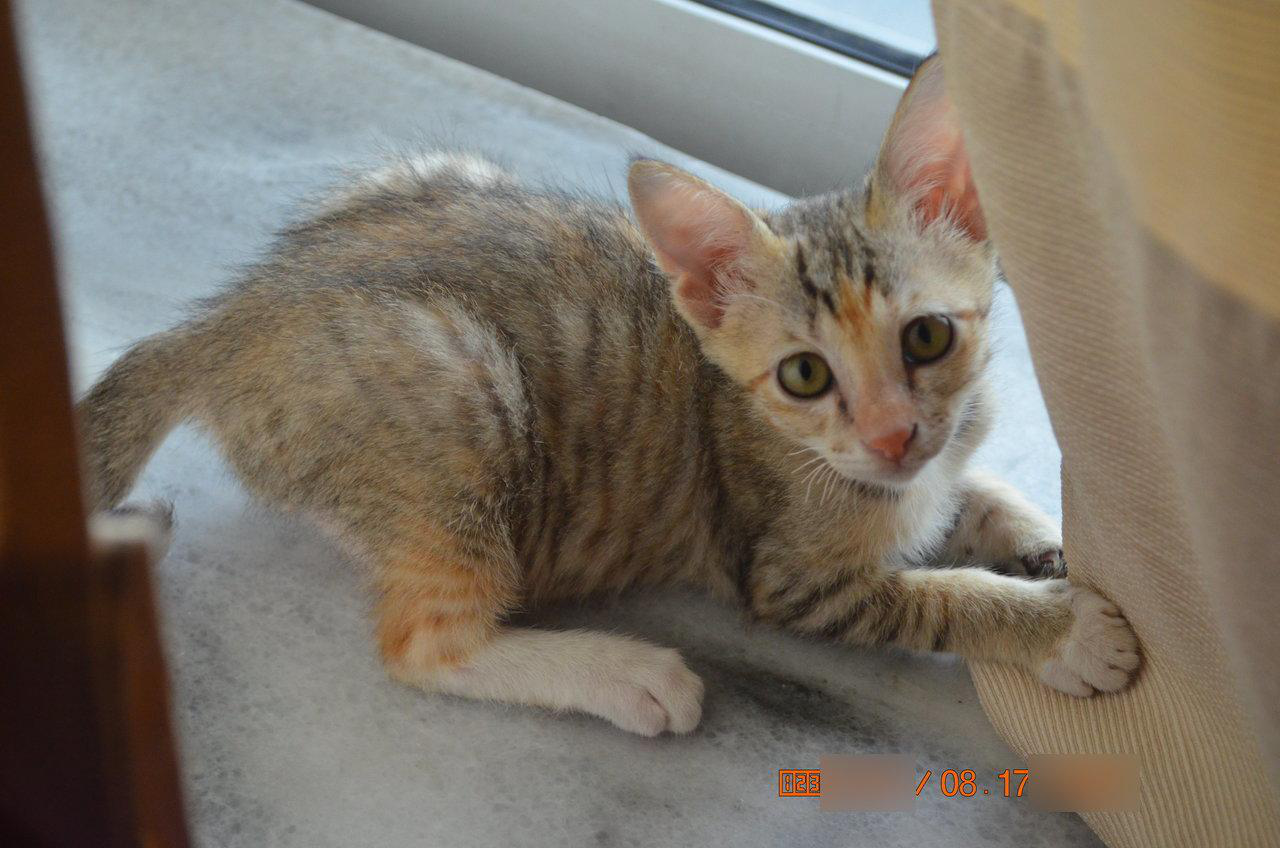

In [3]:
im = Image.open(train_df['path'][0])
width, height = im.size
print(width,height)
im

In [4]:
if not os.path.exists('/root/.cache/torch/hub/checkpoints/'):
    os.makedirs('/root/.cache/torch/hub/checkpoints/')
!cp '../input/swin-transformer/swin_large_patch4_window7_224_22kto1k.pth' '/root/.cache/torch/hub/checkpoints/swin_large_patch4_window7_224_22kto1k.pth'

seed=365
set_seed(seed, reproducible=True)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.use_deterministic_algorithms = True

In [5]:
import math
#Rice rule
num_bins = int(np.ceil(2*((len(train_df))**(1./3))))
num_bins

43

<AxesSubplot:>

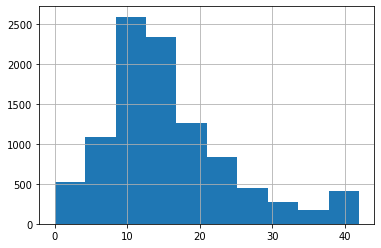

In [6]:
train_df['bins'] = pd.cut(train_df['norm_score'], bins=num_bins, labels=False)
train_df['bins'].hist()

<AxesSubplot:>

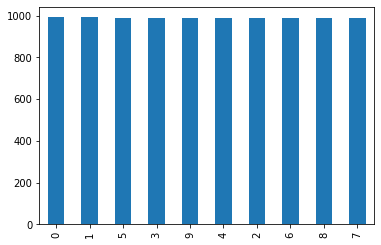

In [7]:
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

train_df['fold'] = -1


N_FOLDS = 10
strat_kfold = StratifiedKFold(n_splits=N_FOLDS, random_state=seed, shuffle=True)
for i, (_, train_index) in enumerate(strat_kfold.split(train_df.index, train_df['bins'])):
    train_df.iloc[train_index, -1] = i
    
train_df['fold'] = train_df['fold'].astype('int')

train_df.fold.value_counts().plot.bar()

In [8]:
display(train_df[train_df['fold']==0].head())
display(train_df[train_df['fold']==1].head())

display(train_df[train_df['fold']==0]['bins'].value_counts())
display(train_df[train_df['fold']==1]['bins'].value_counts())

,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
6,0,1,1,1,0,0,0,0,0,0,0,0,34,../input/petfinder-pawpularity-score/train/87026c16e89f0d04011b90bfb827ad90.jpg,0.34,14,0
22,0,1,1,1,0,0,0,0,0,0,0,0,54,../input/petfinder-pawpularity-score/train/e7bb61a6630101aad7d24ca1e8741788.jpg,0.54,23,0
23,0,1,1,0,0,0,1,0,0,0,0,0,100,../input/petfinder-pawpularity-score/train/f26409c9f5fedae715b44cb7fd2168ed.jpg,1.00,42,0
24,0,0,1,1,0,0,0,0,0,0,0,1,19,../input/petfinder-pawpularity-score/train/5f1dfc3290b10cb22cf2fb16d79ef95d.jpg,0.19,7,0
34,0,1,1,1,0,0,0,0,0,0,0,0,20,../input/petfinder-pawpularity-score/train/d042a84e62e2ab515aefa6f2e45d4947.jpg,0.20,8,0


,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity,path,norm_score,bins,fold
15,0,1,1,1,0,0,0,0,0,0,0,0,37,../input/petfinder-pawpularity-score/train/f6f4cb5044b799dc139301a6eccd9ff8.jpg,0.37,15,1
36,0,1,1,1,0,0,0,0,0,0,0,0,25,../input/petfinder-pawpularity-score/train/2fc98bf59cad537b1fd12cd54dae70c4.jpg,0.25,10,1
46,0,1,1,1,0,0,0,0,0,0,0,0,71,../input/petfinder-pawpularity-score/train/b4df3725315c4b55ed5bdec466608879.jpg,0.71,30,1
53,0,1,1,1,0,0,1,0,0,0,0,0,26,../input/petfinder-pawpularity-score/train/dfd6cc7942b0adb098f2ff61ee96f3d0.jpg,0.26,10,1
56,0,1,1,1,0,0,0,0,1,1,0,0,23,../input/petfinder-pawpularity-score/train/efbc5160aa9e3479da1ca2be2d246c52.jpg,0.23,9,1


13    84
9     75
12    62
11    62
10    60
16    55
14    50
15    46
19    37
17    36
8     36
42    31
7     30
6     28
18    28
20    23
23    22
21    19
0     17
22    16
26    16
5     14
24    13
25    13
4     12
3     11
27    10
29     9
28     8
30     8
33     8
1      7
31     6
32     6
2      6
36     5
37     4
35     4
39     4
34     4
40     3
38     2
41     2
Name: bins, dtype: int64

13    84
9     74
12    62
11    62
10    60
16    55
14    50
15    46
19    37
17    36
8     36
7     31
42    30
18    28
6     27
20    24
23    22
21    19
0     17
22    17
26    16
5     14
24    13
25    13
4     12
3     11
29    10
27    10
28     8
30     8
33     8
1      7
32     6
2      6
31     6
36     5
37     4
34     4
39     4
40     3
35     3
41     2
38     2
Name: bins, dtype: int64

In [9]:
def petfinder_rmse(input,target):
    return 100*torch.sqrt(F.mse_loss(F.sigmoid(input.flatten()), target))

def get_data(fold):
#     train_df_no_val = train_df.query(f'fold != {fold}')
#     train_df_val = train_df.query(f'fold == {fold}')
    
#     train_df_bal = pd.concat([train_df_no_val,train_df_val.sample(frac=1).reset_index(drop=True)])
    train_df_f = train_df.copy()
    # add is_valid for validation fold
    train_df_f['is_valid'] = (train_df_f['fold'] == fold)
    
    dls = ImageDataLoaders.from_df(train_df_f, #pass in train DataFrame
#                                valid_pct=0.2, #80-20 train-validation random split
                               valid_col='is_valid', #
                               seed=365, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) #pass in batch_tfms
    
    return dls

def get_learner(fold_num):
    data = get_data(fold_num)
    
    model = create_model('swin_large_patch4_window7_224', pretrained=True, num_classes=data.c)

    learn = Learner(data, model, loss_func=BCEWithLogitsLossFlat(), metrics=petfinder_rmse).to_fp16()
    
    return learn

In [10]:
#Valid Kfolder size
fold = 0

the_data = get_data(fold)
assert (len(the_data.train) + len(the_data.valid)) == (len(train_df)//BATCH_SIZE)

test_df = pd.read_csv(dataset_path/'test.csv')
test_df.head()

test_df['Pawpularity'] = [1]*len(test_df)
test_df['path'] = test_df['Id'].map(lambda x:str(dataset_path/'test'/x)+'.jpg')
test_df = test_df.drop(columns=['Id'])
train_df['norm_score'] = train_df['Pawpularity']/100

SuggestedLRs(valley=4.828246164834127e-05)

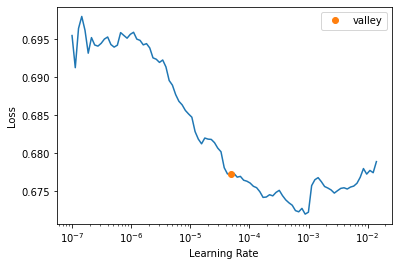

In [11]:
get_learner(fold_num=0).lr_find(end_lr=3e-2)             #was-2

Fold 0 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651857,0.644369,18.061174,07:03
1,0.641825,0.638240,17.242743,07:03
2,0.637231,0.637148,17.020163,07:02
3,0.629899,0.637991,17.126041,07:02
4,0.626949,0.638656,17.202532,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6443687081336975.
Better model found at epoch 1 with valid_loss value: 0.6382401585578918.
Better model found at epoch 2 with valid_loss value: 0.6371477246284485.
No improvement since epoch 2: early stopping


Fold 1 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650439,0.642603,17.714169,07:02
1,0.640408,0.640447,17.324547,07:02
2,0.635711,0.639461,17.200794,07:03
3,0.630434,0.639928,17.239182,07:02
4,0.624569,0.640072,17.237291,07:01


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6426027417182922.
Better model found at epoch 1 with valid_loss value: 0.6404471397399902.
Better model found at epoch 2 with valid_loss value: 0.6394609808921814.
No improvement since epoch 2: early stopping


Fold 2 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647282,0.646678,18.057877,07:02
1,0.642891,0.643952,17.694567,07:02
2,0.637773,0.645908,17.915369,07:02
3,0.630582,0.644729,17.745005,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6466777324676514.
Better model found at epoch 1 with valid_loss value: 0.6439515352249146.
No improvement since epoch 1: early stopping


Fold 3 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.647735,0.646317,18.080715,07:02
1,0.641867,0.644393,17.808807,07:02
2,0.638182,0.645409,17.885139,07:03
3,0.627674,0.644318,17.772282,07:03
4,0.627731,0.644993,17.839821,07:03


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6463174223899841.
Better model found at epoch 1 with valid_loss value: 0.6443928480148315.
Better model found at epoch 3 with valid_loss value: 0.6443180441856384.


Fold 4 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648143,0.643433,17.646767,07:02
1,0.640175,0.642578,17.535049,07:02
2,0.633170,0.640654,17.235617,07:02
3,0.629409,0.641227,17.290049,07:03
4,0.624210,0.641727,17.329941,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6434333324432373.
Better model found at epoch 1 with valid_loss value: 0.6425784230232239.
Better model found at epoch 2 with valid_loss value: 0.6406543254852295.
No improvement since epoch 2: early stopping


Fold 5 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.651138,0.651090,18.798882,07:03
1,0.638343,0.646585,18.218321,07:03
2,0.636866,0.644028,17.888889,07:02
3,0.632009,0.644266,17.882668,07:02
4,0.627708,0.644384,17.906145,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6510902047157288.
Better model found at epoch 1 with valid_loss value: 0.6465854048728943.
Better model found at epoch 2 with valid_loss value: 0.6440281867980957.


Fold 6 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650491,0.645014,17.920132,07:02
1,0.641631,0.640818,17.319181,07:02
2,0.634865,0.640647,17.208792,07:01
3,0.627898,0.640959,17.280272,07:02
4,0.626560,0.641395,17.308842,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.645014226436615.
Better model found at epoch 1 with valid_loss value: 0.6408179998397827.
Better model found at epoch 2 with valid_loss value: 0.6406468749046326.
No improvement since epoch 2: early stopping


Fold 7 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.648298,0.641081,17.535051,07:02
1,0.644610,0.638183,17.139364,07:02
2,0.634907,0.636305,16.850605,07:02
3,0.629518,0.636239,16.842279,07:03
4,0.627835,0.636137,16.810133,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6410810947418213.
Better model found at epoch 1 with valid_loss value: 0.6381834149360657.
Better model found at epoch 2 with valid_loss value: 0.6363051533699036.
Better model found at epoch 3 with valid_loss value: 0.6362391710281372.
Better model found at epoch 4 with valid_loss value: 0.6361367106437683.


Fold 8 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.649867,0.644528,17.999676,07:02
1,0.643924,0.641394,17.609423,07:02
2,0.634532,0.637253,17.015991,07:02
3,0.631761,0.637736,17.086588,07:02
4,0.624535,0.637745,17.088860,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6445280909538269.
Better model found at epoch 1 with valid_loss value: 0.6413941979408264.
Better model found at epoch 2 with valid_loss value: 0.637252926826477.
No improvement since epoch 2: early stopping


Fold 9 results


epoch,train_loss,valid_loss,petfinder_rmse,time
0,0.650886,0.640332,17.540247,07:02
1,0.639768,0.637203,17.146114,07:01
2,0.641050,0.634692,16.819956,07:02
3,0.630573,0.635757,16.922634,07:02
4,0.628126,0.635094,16.862801,07:02


/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Better model found at epoch 0 with valid_loss value: 0.6403321623802185.
Better model found at epoch 1 with valid_loss value: 0.6372028589248657.
Better model found at epoch 2 with valid_loss value: 0.6346920728683472.
No improvement since epoch 2: early stopping


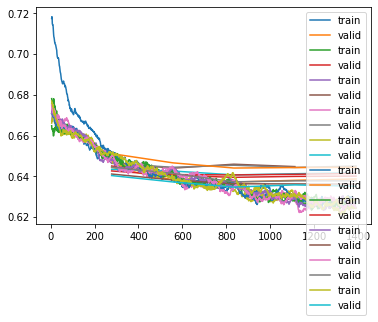

In [12]:
all_preds = []

for i in range(N_FOLDS):

    print(f'Fold {i} results')
    
    learn = get_learner(fold_num=i)

    learn.fit_one_cycle(5, 2e-5, cbs=[SaveModelCallback(), EarlyStoppingCallback(monitor='petfinder_rmse', comp=np.less, patience=2)]) 
    
    learn.recorder.plot_loss()

    #learn = learn.to_fp32()
    
    #learn.export(f'model_fold_{i}.pkl')
    #learn.save(f'model_fold_{i}.pkl')
    
    dls = ImageDataLoaders.from_df(train_df, #pass in train DataFrame
                               valid_pct=0.2, #80-20 train-validation random split
                               seed=365, #seed
                               fn_col='path', #filename/path is in the second column of the DataFrame
                               label_col='norm_score', #label is in the first column of the DataFrame
                               y_block=RegressionBlock, #The type of target
                               bs=BATCH_SIZE, #pass in batch size
                               num_workers=8,
                               item_tfms=Resize(224), #pass in item_tfms
                               batch_tfms=setup_aug_tfms([Brightness(), Contrast(), Hue(), Saturation()])) 
    
    test_dl = dls.test_dl(test_df)
    
    preds, _ = learn.tta(dl=test_dl, n=5, beta=0)
    
    all_preds.append(preds)
    
    del learn

    torch.cuda.empty_cache()

    gc.collect()

In [13]:
all_preds

[tensor([[0.4701],
         [0.4502],
         [0.4654],
         [0.4577],
         [0.4430],
         [0.4485],
         [0.4517],
         [0.4704]]),
 tensor([[0.5145],
         [0.5154],
         [0.5161],
         [0.5126],
         [0.5017],
         [0.5047],
         [0.5141],
         [0.5174]]),
 tensor([[0.5002],
         [0.5000],
         [0.4988],
         [0.4923],
         [0.4876],
         [0.4902],
         [0.5038],
         [0.5084]]),
 tensor([[0.5076],
         [0.5036],
         [0.5132],
         [0.5065],
         [0.4939],
         [0.4965],
         [0.5083],
         [0.5115]]),
 tensor([[0.4853],
         [0.4839],
         [0.4909],
         [0.4947],
         [0.4759],
         [0.4813],
         [0.4870],
         [0.4920]]),
 tensor([[0.4969],
         [0.4908],
         [0.4977],
         [0.4970],
         [0.4873],
         [0.4920],
         [0.4930],
         [0.5020]]),
 tensor([[0.5018],
         [0.5036],
         [0.4965],
         [0.4954],


In [14]:
np.mean(np.stack(all_preds*100))

0.495645

In [15]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')
preds = np.mean(np.stack(all_preds), axis=0)
sample_df['Pawpularity'] = preds*100
sample_df.to_csv('submission.csv',index=False)

In [16]:
pd.read_csv('submission.csv').head()

,Id,Pawpularity
0,4128bae22183829d2b5fea10effdb0c3,49.857520
1,43a2262d7738e3d420d453815151079e,49.527200
2,4e429cead1848a298432a0acad014c9d,49.960310
3,80bc3ccafcc51b66303c2c263aa38486,49.590214
4,8f49844c382931444e68dffbe20228f4,48.445970
